In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'enet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 755.65it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:09<00:00, 34.15img/s]

***
enet Loss: 1.1260602474212646


Epoch 1/50:  99%|█████████▊| 200/203 [00:12<00:00, 16.46img/s]


---
enet Validation Dice Loss: 1.1270020008087158
enet Validation Pixel Accuracy: 0.6263872113144189
enet Validation MIoU: 0.3602774181924893
enet Validation Dice Score: 0.2163747400045395


Epoch 2/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.37img/s]

***
enet Loss: 1.0513699054718018


Epoch 2/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.68img/s]


---
enet Validation Dice Loss: 1.0770890712738037
enet Validation Pixel Accuracy: 0.6589368853652686
enet Validation MIoU: 0.38737918981881064
enet Validation Dice Score: 0.2593488395214081


Epoch 3/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.49img/s]

***
enet Loss: 0.9522313475608826


Epoch 3/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.87img/s]


---
enet Validation Dice Loss: 0.9524632692337036
enet Validation Pixel Accuracy: 0.7410725376062226
enet Validation MIoU: 0.45119128289360344
enet Validation Dice Score: 0.3267397880554199


Epoch 4/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.09img/s]

***
enet Loss: 0.8701902627944946


Epoch 4/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.52img/s]


---
enet Validation Dice Loss: 0.8602888584136963
enet Validation Pixel Accuracy: 0.797543442040159
enet Validation MIoU: 0.5140184521522934
enet Validation Dice Score: 0.42460450530052185


Epoch 5/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.84img/s]

***
enet Loss: 0.7782405614852905


Epoch 5/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.31img/s]


---
enet Validation Dice Loss: 0.7663561105728149
enet Validation Pixel Accuracy: 0.8425057394462719
enet Validation MIoU: 0.5785267847238046
enet Validation Dice Score: 0.5140596032142639


Epoch 6/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.41img/s]

***
enet Loss: 0.7024536728858948


Epoch 6/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.85img/s]


---
enet Validation Dice Loss: 0.7040326595306396
enet Validation Pixel Accuracy: 0.8596477843167489
enet Validation MIoU: 0.6148671127415765
enet Validation Dice Score: 0.5746508240699768


Epoch 7/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.13img/s]

***
enet Loss: 0.6780216693878174


Epoch 7/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.39img/s]


---
enet Validation Dice Loss: 0.6275978088378906
enet Validation Pixel Accuracy: 0.8824594062671327
enet Validation MIoU: 0.6547072448404537
enet Validation Dice Score: 0.6260896921157837


Epoch 8/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.40img/s]

***
enet Loss: 0.6239622235298157


Epoch 8/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.01img/s]


---
enet Validation Dice Loss: 0.5685449838638306
enet Validation Pixel Accuracy: 0.8996830990439967
enet Validation MIoU: 0.6908652929845956
enet Validation Dice Score: 0.6612109541893005


Epoch 9/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.40img/s]

***
enet Loss: 0.5281939506530762


Epoch 9/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.90img/s]


---
enet Validation Dice Loss: 0.5259929895401001
enet Validation Pixel Accuracy: 0.9038433944969847
enet Validation MIoU: 0.701730338846337
enet Validation Dice Score: 0.6899401545524597


Epoch 10/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.31img/s]

***
enet Loss: 0.49487438797950745


Epoch 10/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.00img/s]


---
enet Validation Dice Loss: 0.4970700740814209
enet Validation Pixel Accuracy: 0.907527722810444
enet Validation MIoU: 0.7032371691863746
enet Validation Dice Score: 0.6952885985374451


Epoch 11/50:  99%|█████████▊| 200/203 [00:07<00:00, 34.69img/s]

***
enet Loss: 0.4701458811759949


Epoch 11/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.56img/s]


---
enet Validation Dice Loss: 0.4703887701034546
enet Validation Pixel Accuracy: 0.9090030067845395
enet Validation MIoU: 0.71257592916913
enet Validation Dice Score: 0.7073071599006653


Epoch 12/50:  99%|█████████▊| 200/203 [00:07<00:00, 38.71img/s]

***
enet Loss: 0.4711572229862213


Epoch 12/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.01img/s]


---
enet Validation Dice Loss: 0.4482153058052063
enet Validation Pixel Accuracy: 0.909948516310307
enet Validation MIoU: 0.7057871192651312
enet Validation Dice Score: 0.708121120929718


Epoch 13/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.16img/s]

***
enet Loss: 0.46352246403694153


Epoch 13/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.83img/s]


---
enet Validation Dice Loss: 0.4219478666782379
enet Validation Pixel Accuracy: 0.9135469135485197
enet Validation MIoU: 0.7230931279944606
enet Validation Dice Score: 0.7170941233634949


Epoch 14/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.43img/s]

***
enet Loss: 0.37974363565444946


Epoch 14/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.86img/s]


---
enet Validation Dice Loss: 0.40384265780448914
enet Validation Pixel Accuracy: 0.9148605078981634
enet Validation MIoU: 0.719538933997631
enet Validation Dice Score: 0.727733314037323


Epoch 15/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.20img/s]

***
enet Loss: 0.4129471778869629


Epoch 15/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.16img/s]


---
enet Validation Dice Loss: 0.3876146078109741
enet Validation Pixel Accuracy: 0.918426513671875
enet Validation MIoU: 0.7336340602219286
enet Validation Dice Score: 0.7336493134498596


Epoch 16/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.41img/s]

***
enet Loss: 0.38451144099235535


Epoch 16/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.94img/s]


---
enet Validation Dice Loss: 0.3766005039215088
enet Validation Pixel Accuracy: 0.9194175318667763
enet Validation MIoU: 0.7451879138808739
enet Validation Dice Score: 0.7539021372795105


Epoch 17/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.79img/s]

***
enet Loss: 0.3532130718231201


Epoch 17/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.04img/s]


---
enet Validation Dice Loss: 0.3470129668712616
enet Validation Pixel Accuracy: 0.9325205485026041
enet Validation MIoU: 0.7789386048748492
enet Validation Dice Score: 0.7963863015174866


Epoch 18/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.68img/s]

***
enet Loss: 0.36466118693351746


Epoch 18/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.52img/s]


---
enet Validation Dice Loss: 0.3384091854095459
enet Validation Pixel Accuracy: 0.9354245369894463
enet Validation MIoU: 0.7933241543954344
enet Validation Dice Score: 0.821215808391571


Epoch 19/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.49img/s]

***
enet Loss: 0.34463196992874146


Epoch 19/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.77img/s]


---
enet Validation Dice Loss: 0.32879406213760376
enet Validation Pixel Accuracy: 0.938040482370477
enet Validation MIoU: 0.8006350507398132
enet Validation Dice Score: 0.8478946089744568


Epoch 20/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.47img/s]

***
enet Loss: 0.28352758288383484


Epoch 20/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.53img/s]


---
enet Validation Dice Loss: 0.31303441524505615
enet Validation Pixel Accuracy: 0.9399633574904057
enet Validation MIoU: 0.8129106085517062
enet Validation Dice Score: 0.848451554775238


Epoch 21/50:  99%|█████████▊| 200/203 [00:07<00:00, 34.52img/s]

***
enet Loss: 0.27834147214889526


Epoch 21/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.57img/s]


---
enet Validation Dice Loss: 0.305794894695282
enet Validation Pixel Accuracy: 0.9392892937911185
enet Validation MIoU: 0.8061749015932391
enet Validation Dice Score: 0.8369438052177429


Epoch 22/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.61img/s]

***
enet Loss: 0.26573532819747925


Epoch 22/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.08img/s]


---
enet Validation Dice Loss: 0.29861027002334595
enet Validation Pixel Accuracy: 0.939165617290296
enet Validation MIoU: 0.8096883376662452
enet Validation Dice Score: 0.8603057265281677


Epoch 23/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.31img/s]

***
enet Loss: 0.2170548439025879


Epoch 23/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.74img/s]


---
enet Validation Dice Loss: 0.27015581727027893
enet Validation Pixel Accuracy: 0.9441959314179003
enet Validation MIoU: 0.8205113468511984
enet Validation Dice Score: 0.8699542284011841


Epoch 24/50:  99%|█████████▊| 200/203 [00:07<00:00, 40.36img/s]

***
enet Loss: 0.2202005833387375


Epoch 24/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.12img/s]


---
enet Validation Dice Loss: 0.2726902365684509
enet Validation Pixel Accuracy: 0.9409599973444354
enet Validation MIoU: 0.8163825735595491
enet Validation Dice Score: 0.8626301884651184


Epoch 25/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.76img/s]

***
enet Loss: 0.23283669352531433


Epoch 25/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.62img/s]


---
enet Validation Dice Loss: 0.24649231135845184
enet Validation Pixel Accuracy: 0.9472458153440241
enet Validation MIoU: 0.827488797010539
enet Validation Dice Score: 0.8749490976333618


Epoch 26/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.77img/s]

***
enet Loss: 0.23484154045581818


Epoch 26/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.53img/s]


---
enet Validation Dice Loss: 0.24746690690517426
enet Validation Pixel Accuracy: 0.9460462603652686
enet Validation MIoU: 0.824977392766166
enet Validation Dice Score: 0.8689014315605164


Epoch 27/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.09img/s]

***
enet Loss: 0.26441290974617004


Epoch 27/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.07img/s]


---
enet Validation Dice Loss: 0.20975539088249207
enet Validation Pixel Accuracy: 0.9583135236773574
enet Validation MIoU: 0.8581990935929783
enet Validation Dice Score: 0.8665637373924255


Epoch 28/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.53img/s]

***
enet Loss: 0.21223300695419312


Epoch 28/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.28img/s]


---
enet Validation Dice Loss: 0.2124778777360916
enet Validation Pixel Accuracy: 0.9553501062225878
enet Validation MIoU: 0.8508249746767531
enet Validation Dice Score: 0.8769159317016602


Epoch 29/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.01img/s]

***
enet Loss: 0.195692777633667


Epoch 29/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.29img/s]


---
enet Validation Dice Loss: 0.24831555783748627
enet Validation Pixel Accuracy: 0.9438366806297972
enet Validation MIoU: 0.8242284694724183
enet Validation Dice Score: 0.872579038143158


Epoch 30/50:  99%|█████████▊| 200/203 [00:07<00:00, 34.47img/s]

***
enet Loss: 0.18229642510414124


Epoch 30/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.54img/s]


---
enet Validation Dice Loss: 0.22046861052513123
enet Validation Pixel Accuracy: 0.9498970968681469
enet Validation MIoU: 0.8367720291981582
enet Validation Dice Score: 0.8824501037597656


Epoch 31/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.61img/s]

***
enet Loss: 0.15826848149299622


Epoch 31/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.66img/s]


---
enet Validation Dice Loss: 0.19966234266757965
enet Validation Pixel Accuracy: 0.9558132238555372
enet Validation MIoU: 0.8500760975572814
enet Validation Dice Score: 0.8849254846572876


Epoch 32/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.38img/s]

***
enet Loss: 0.17172828316688538


Epoch 32/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.73img/s]


---
enet Validation Dice Loss: 0.21509411931037903
enet Validation Pixel Accuracy: 0.948949981154057
enet Validation MIoU: 0.8333108117444105
enet Validation Dice Score: 0.8902058005332947


Epoch 33/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.41img/s]

***
enet Loss: 0.28205710649490356


Epoch 33/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.72img/s]


---
enet Validation Dice Loss: 0.17515671253204346
enet Validation Pixel Accuracy: 0.9631468120374178
enet Validation MIoU: 0.8738455586405109
enet Validation Dice Score: 0.8857633471488953


Epoch 34/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.55img/s]

***
enet Loss: 0.12180864810943604


Epoch 34/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.75img/s]


---
enet Validation Dice Loss: 0.1731371134519577
enet Validation Pixel Accuracy: 0.962624800832648
enet Validation MIoU: 0.8698628126983232
enet Validation Dice Score: 0.8864647746086121


Epoch 35/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.52img/s]

***
enet Loss: 0.14565441012382507


Epoch 35/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.03img/s]


---
enet Validation Dice Loss: 0.1749754250049591
enet Validation Pixel Accuracy: 0.960584138569079
enet Validation MIoU: 0.8659732120015393
enet Validation Dice Score: 0.8886765837669373


Epoch 36/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.78img/s]

***
enet Loss: 0.12555831670761108


Epoch 36/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.77img/s]


---
enet Validation Dice Loss: 0.17058831453323364
enet Validation Pixel Accuracy: 0.962459363435444
enet Validation MIoU: 0.8714347951709634
enet Validation Dice Score: 0.8902417421340942


Epoch 37/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.29img/s]

***
enet Loss: 0.15810012817382812


Epoch 37/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.71img/s]


---
enet Validation Dice Loss: 0.1838083416223526
enet Validation Pixel Accuracy: 0.9574563545093202
enet Validation MIoU: 0.8580142287356369
enet Validation Dice Score: 0.8897805213928223


Epoch 38/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.24img/s]

***
enet Loss: 0.201102614402771


Epoch 38/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.46img/s]


---
enet Validation Dice Loss: 0.16614088416099548
enet Validation Pixel Accuracy: 0.9630951463130483
enet Validation MIoU: 0.8731702230076226
enet Validation Dice Score: 0.8920788168907166


Epoch 39/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.37img/s]

***
enet Loss: 0.1412563920021057


Epoch 39/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.76img/s]


---
enet Validation Dice Loss: 0.16951611638069153
enet Validation Pixel Accuracy: 0.9617494281969572
enet Validation MIoU: 0.8697949833326826
enet Validation Dice Score: 0.890998363494873


Epoch 40/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.12img/s]

***
enet Loss: 0.19730183482170105


Epoch 40/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.57img/s]


---
enet Validation Dice Loss: 0.16541875898838043
enet Validation Pixel Accuracy: 0.9630828322025767
enet Validation MIoU: 0.8732731868264878
enet Validation Dice Score: 0.8921771049499512


Epoch 41/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.71img/s]

***
enet Loss: 0.15849569439888


Epoch 41/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.33img/s]


---
enet Validation Dice Loss: 0.17491063475608826
enet Validation Pixel Accuracy: 0.9587750351219847
enet Validation MIoU: 0.8608549128027159
enet Validation Dice Score: 0.8934940695762634


Epoch 42/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.62img/s]

***
enet Loss: 0.19697095453739166


Epoch 42/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.86img/s]


---
enet Validation Dice Loss: 0.167069673538208
enet Validation Pixel Accuracy: 0.9620741459361294
enet Validation MIoU: 0.8707930171274204
enet Validation Dice Score: 0.8930121660232544


Epoch 43/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.81img/s]

***
enet Loss: 0.1152525544166565


Epoch 43/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.95img/s]


---
enet Validation Dice Loss: 0.17172753810882568
enet Validation Pixel Accuracy: 0.9603003786321271
enet Validation MIoU: 0.8661959628107554
enet Validation Dice Score: 0.8920041918754578


Epoch 44/50:  99%|█████████▊| 200/203 [00:07<00:00, 39.34img/s]

***
enet Loss: 0.15302670001983643


Epoch 44/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.34img/s]


---
enet Validation Dice Loss: 0.16726446151733398
enet Validation Pixel Accuracy: 0.9609540972793311
enet Validation MIoU: 0.8666215022169241
enet Validation Dice Score: 0.8939254879951477


Epoch 45/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.01img/s]

***
enet Loss: 0.1568661630153656


Epoch 45/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.66img/s]


---
enet Validation Dice Loss: 0.16792279481887817
enet Validation Pixel Accuracy: 0.9612110874109101
enet Validation MIoU: 0.8680380221131742
enet Validation Dice Score: 0.8939957022666931


Epoch 46/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.45img/s]

***
enet Loss: 0.1465930938720703


Epoch 46/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.66img/s]


---
enet Validation Dice Loss: 0.1518908143043518
enet Validation Pixel Accuracy: 0.9668817352830318
enet Validation MIoU: 0.884121417993744
enet Validation Dice Score: 0.8954814076423645


Epoch 47/50:  99%|█████████▊| 200/203 [00:07<00:00, 38.08img/s]

***
enet Loss: 0.1357680857181549


Epoch 47/50:  99%|█████████▊| 200/203 [00:09<00:00, 20.10img/s]


---
enet Validation Dice Loss: 0.16510657966136932
enet Validation Pixel Accuracy: 0.9626320286800987
enet Validation MIoU: 0.8730422571293315
enet Validation Dice Score: 0.8922123312950134


Epoch 48/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.56img/s]

***
enet Loss: 0.13251012563705444


Epoch 48/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.86img/s]


---
enet Validation Dice Loss: 0.1650136411190033
enet Validation Pixel Accuracy: 0.9620425575657895
enet Validation MIoU: 0.8708187915357719
enet Validation Dice Score: 0.8931078910827637


Epoch 49/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.05img/s]

***
enet Loss: 0.1122300922870636


Epoch 49/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.42img/s]


---
enet Validation Dice Loss: 0.15919546782970428
enet Validation Pixel Accuracy: 0.9639159085457785
enet Validation MIoU: 0.8755458880524873
enet Validation Dice Score: 0.8947467803955078


Epoch 50/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.40img/s]

***
enet Loss: 0.13297998905181885


Epoch 50/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.68img/s]

---
enet Validation Dice Loss: 0.16435915231704712
enet Validation Pixel Accuracy: 0.9621442828262061
enet Validation MIoU: 0.871141981918883
enet Validation Dice Score: 0.8942389488220215


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

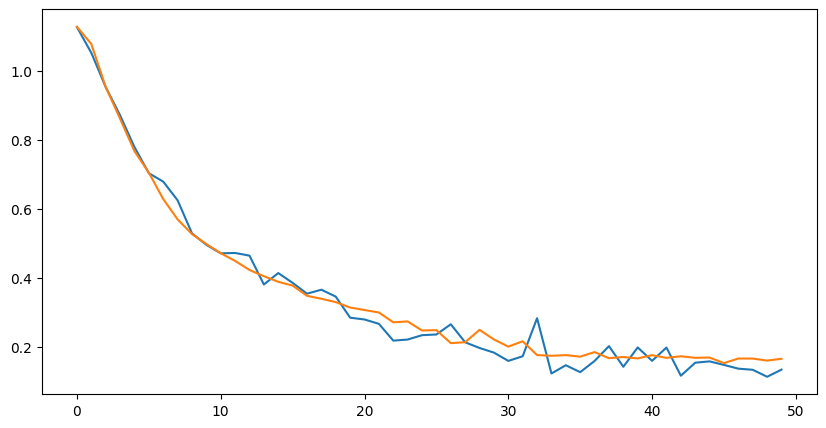

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

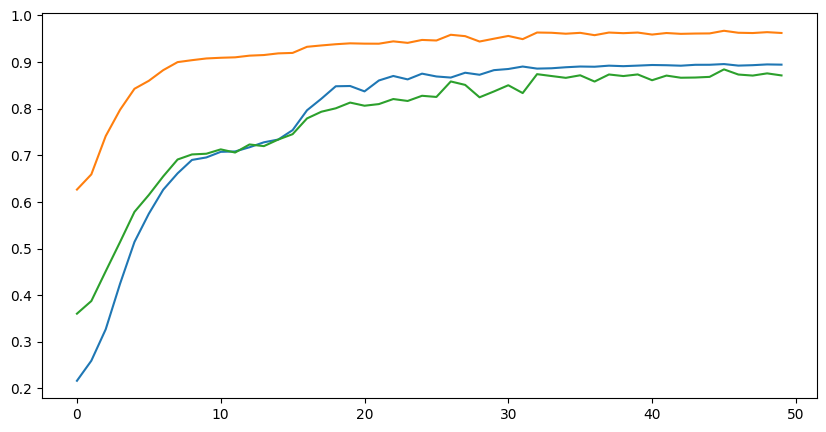

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)